In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geojson import Point, Feature, FeatureCollection, dump

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score

from scipy.spatial.distance import cdist

import math

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

In [2]:
ph = gpd.read_file('data/Philippines_Solar/Barangays_Solar_Data.geojson')
ph.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,PROVINCE,REGION,GHI_mean,GHI_min,GHI_max,DIF_mean,DIF_min,DIF_max,DNI_mean,DNI_min,DNI_max,GTI_mean,GTI_min,GTI_max,OPTA_mean,OPTA_min,OPTA_max,PVOUT_mean,PVOUT_min,PVOUT_max,TEMP_mean,TEMP_min,TEMP_max,geometry
0,177,PHL,Philippines,1,Abra,16,Manabo,172,San Jose Norte,None,None,Barangay,Village,Abra,Cordillera Administrative Region (CAR),1972.681335,1912.448975,1983.307983,732.932439,715.890015,738.536011,1772.840666,1606.734985,1799.222046,2075.214970,2010.701050,2089.594971,20.000000,20.0,20.0,1623.170833,1609.291992,1631.937012,27.330769,26.400000,27.799999,"MULTIPOLYGON (((120.70043 17.45648, 120.70312 ..."
1,177,PHL,Philippines,1,Abra,16,Manabo,173,San Jose Sur,None,None,Barangay,Village,Abra,Cordillera Administrative Region (CAR),1967.001718,1944.225952,1977.098022,733.630674,724.656006,736.708984,1765.331617,1709.005005,1787.167969,2067.367113,2042.843018,2081.560059,20.000000,20.0,20.0,1617.967421,1606.369019,1624.996948,27.398231,26.799999,27.799999,"MULTIPOLYGON (((120.74783 17.44496, 120.74841 ..."
2,177,PHL,Philippines,1,Abra,16,Manabo,174,San Juan Norte,None,None,Barangay,Village,Abra,Cordillera Administrative Region (CAR),1966.958687,1939.478027,1976.733032,738.551295,729.039001,745.474976,1762.934679,1699.508057,1793.011963,2069.879671,2039.191040,2082.290039,20.008457,20.0,21.0,1622.878809,1611.848022,1640.703003,27.040000,25.600000,27.799999,"MULTIPOLYGON (((120.69788 17.43542, 120.70522 ..."
3,177,PHL,Philippines,1,Abra,16,Manabo,175,San Juan Sur,None,None,Barangay,Village,Abra,Cordillera Administrative Region (CAR),1962.424855,1916.832031,1973.446045,739.567711,725.385986,745.840027,1754.541928,1660.426025,1787.167969,2065.036090,2014.718994,2079.732910,20.008484,20.0,21.0,1619.031331,1604.542969,1632.302002,26.766667,26.100000,27.600000,"MULTIPOLYGON (((120.66516 17.42832, 120.70497 ..."
4,177,PHL,Philippines,1,Abra,16,Manabo,176,San Ramon East,None,None,Barangay,Village,Abra,Cordillera Administrative Region (CAR),1903.905352,1811.640015,1962.123047,751.609724,736.708984,772.504028,1642.933283,1465.748047,1759.774048,1998.892135,1897.473999,2064.758057,20.000000,20.0,20.0,1570.199021,1535.510986,1603.447998,26.408823,24.600000,27.700001,"MULTIPOLYGON (((120.70567 17.42277, 120.76253 ..."


In [3]:
nan_index = ph.index[ph.PVOUT_mean.isnull()].values
# Impute based on Location
for index in nan_index:
    loc_name = ph.loc[index,"NAME_2"]
    imputed_value = ph[ph['NAME_2'] == loc_name].mean().values[0]
    ph.loc[index,'PVOUT_mean'] = imputed_value

In [4]:
pv_out = ph['PVOUT_mean']
pv_out = pv_out.to_numpy()
pv_out = pv_out.reshape(-1,1)
scaler = RobustScaler()
pv_out= scaler.fit_transform(pv_out)

In [5]:
print(pv_out.shape)

(41933, 1)


In [6]:
neighbors = NearestNeighbors(n_neighbors = 20)
neighbors_fit = neighbors.fit(pv_out)
distances, indices = neighbors_fit.kneighbors(pv_out)

### Knee Plot

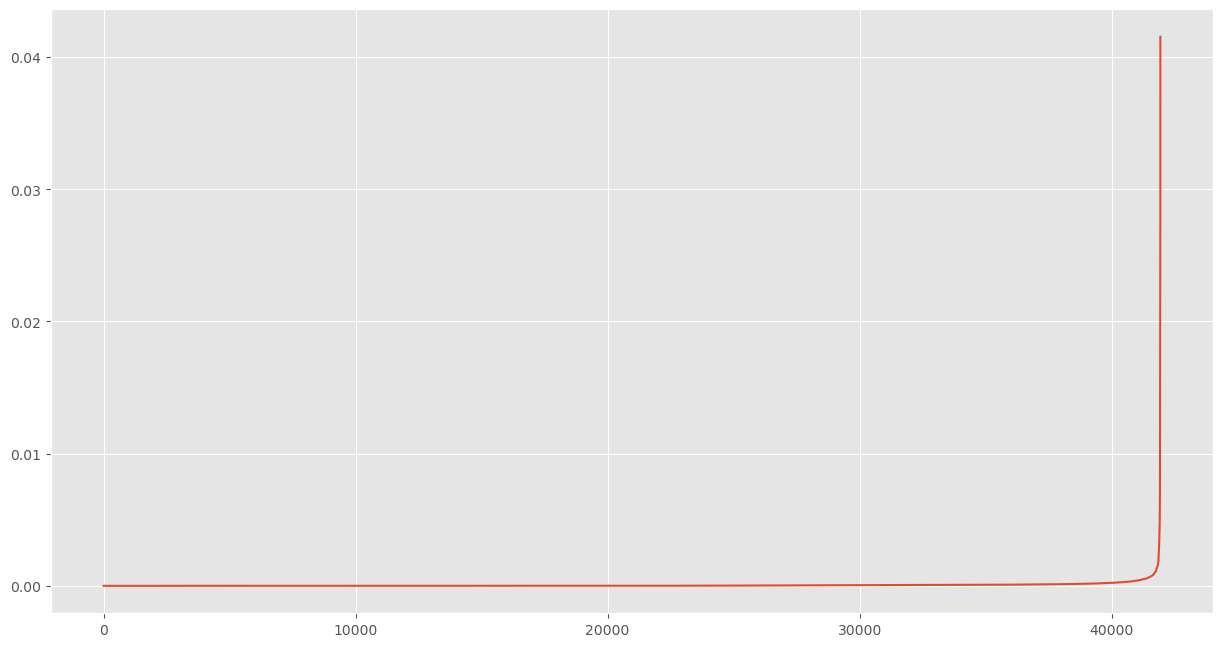

In [7]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

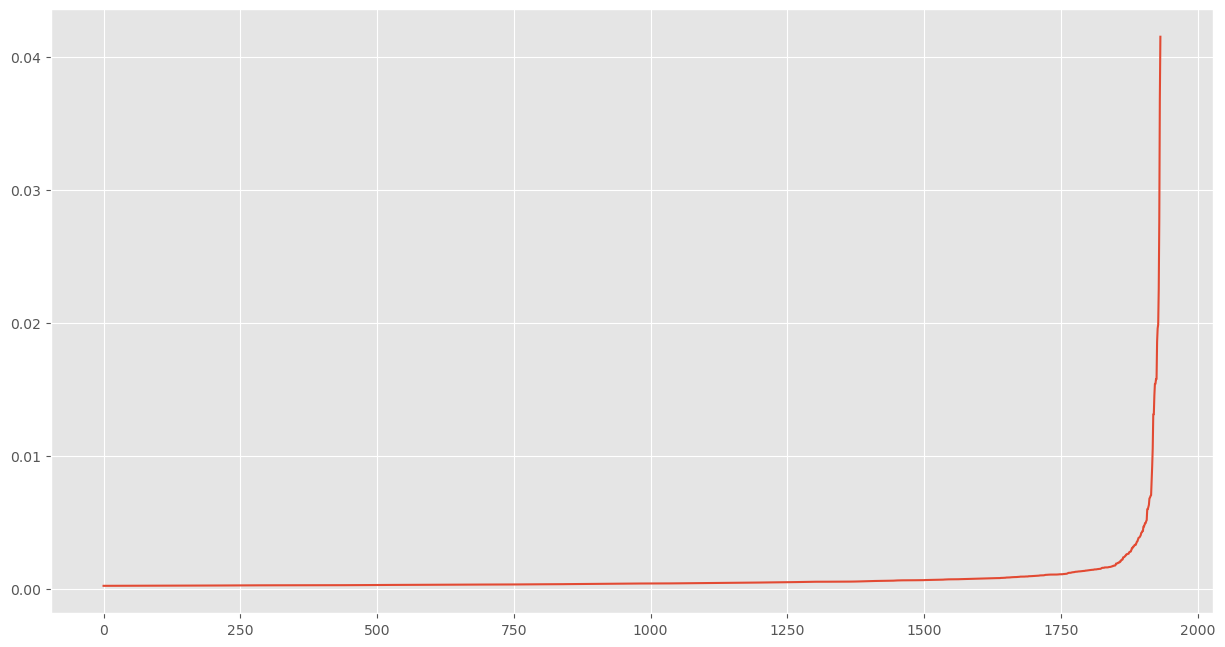

In [8]:
distances = distances[40000:41933]
plt.plot(distances)

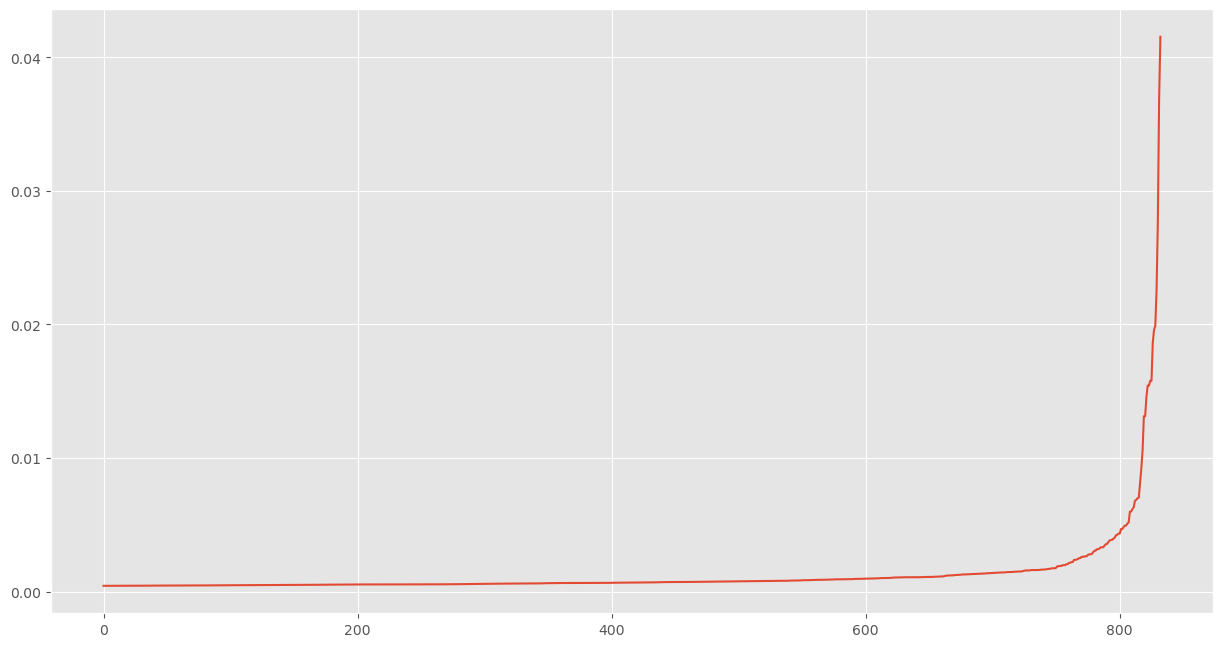

In [9]:
distances = distances[1100:1933]
plt.plot(distances)

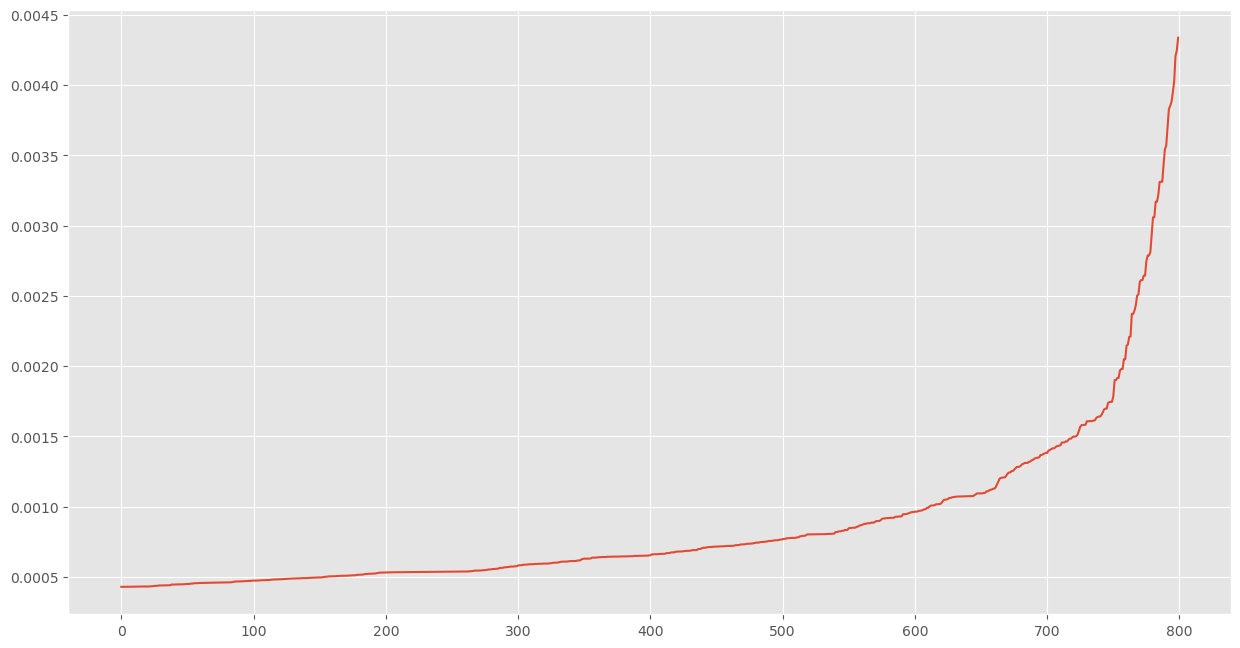

In [10]:
distances = distances[0:800]
plt.plot(distances)

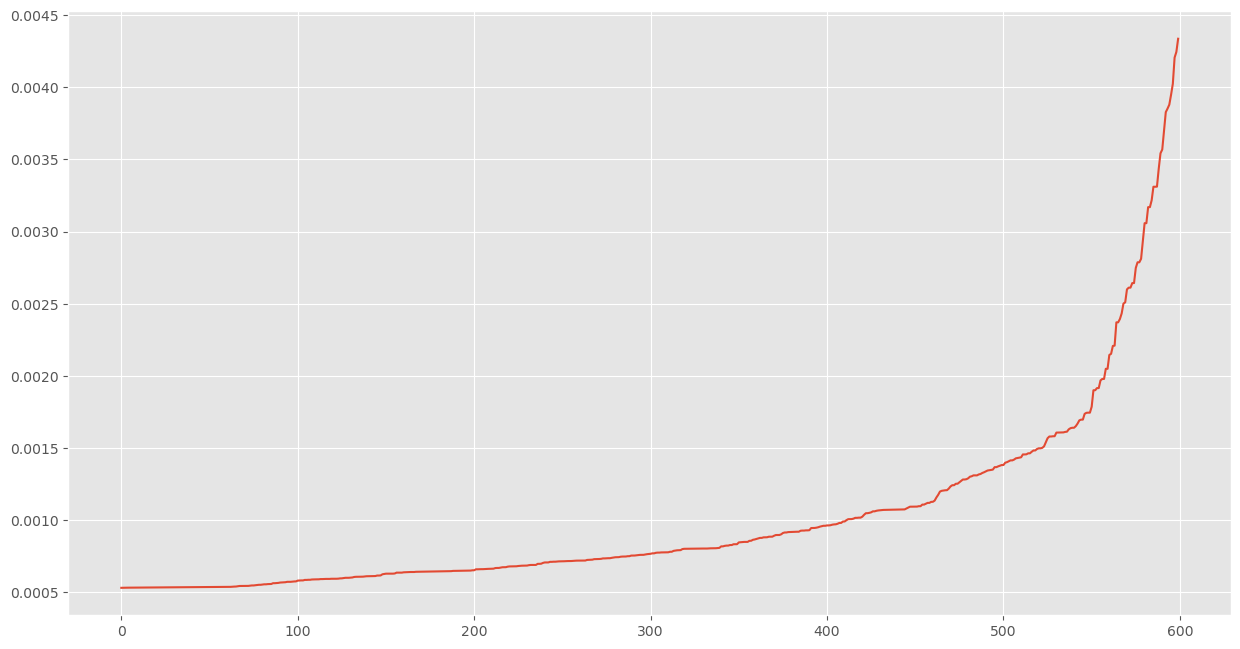

In [11]:
distances = distances[200:800]
plt.plot(distances)

In [12]:
len(distances)

600

In [13]:
silhouette_scores = []

for eps in distances:
    
    # Building and fitting the model
    db = DBSCAN(eps = eps, min_samples = 20)
    db.fit(pv_out)
    
    pred_clusters = db.labels_
    n_clusters    = len(set(pred_clusters))
    if n_clusters > 1:
        silhouette = silhouette_score(pv_out,pred_clusters)
        silhouette_scores.append(silhouette)
        print("Silhouette score for eps {} with number of cluster(s) {}: {}".format(eps, n_clusters, silhouette))
        
    else:
        print("No Silhouette score for eps {} with number of cluster(s) {}".format(eps, n_clusters))

Silhouette score for eps 0.0005316542666289337 with number of cluster(s) 523: 0.015342951136209648
Silhouette score for eps 0.0005322816401722719 with number of cluster(s) 519: 0.01623205034811732
Silhouette score for eps 0.0005322816401722719 with number of cluster(s) 519: 0.01623205034811732
Silhouette score for eps 0.0005327297641342099 with number of cluster(s) 519: 0.01694028841119232
Silhouette score for eps 0.0005327297641342099 with number of cluster(s) 519: 0.01694028841119232
Silhouette score for eps 0.00053281938892491 with number of cluster(s) 519: 0.01700758889588788
Silhouette score for eps 0.0005328193889269084 with number of cluster(s) 519: 0.01700758889588788
Silhouette score for eps 0.0005329090137176085 with number of cluster(s) 519: 0.01700758889588788
Silhouette score for eps 0.000532940440594043 with number of cluster(s) 520: 0.0178508809834971
Silhouette score for eps 0.000533088263301229 with number of cluster(s) 521: 0.01754269803731824
Silhouette score for eps

Silhouette score for eps 0.0005574200656184303 with number of cluster(s) 380: -3.594443048922169e-05
Silhouette score for eps 0.000557618568894247 with number of cluster(s) 380: -6.898060379998972e-06
Silhouette score for eps 0.0005583231141774725 with number of cluster(s) 379: 0.0014192938677719713
Silhouette score for eps 0.0005636818462253501 with number of cluster(s) 367: 0.005995356379760449
Silhouette score for eps 0.0005636818462253501 with number of cluster(s) 367: 0.005995356379760449
Silhouette score for eps 0.0005645275648327175 with number of cluster(s) 364: 0.009582449533717433
Silhouette score for eps 0.0005657749521787991 with number of cluster(s) 362: 0.009377636656246533
Silhouette score for eps 0.0005681901519842825 with number of cluster(s) 353: 0.00813006604083295
Silhouette score for eps 0.0005689527138839079 with number of cluster(s) 354: 0.00862784518826279
Silhouette score for eps 0.0005689527138839079 with number of cluster(s) 354: 0.00862784518826279
Silhouett

Silhouette score for eps 0.0006427173089758043 with number of cluster(s) 203: 0.007921331037172576
Silhouette score for eps 0.0006429324084780141 with number of cluster(s) 201: 0.016307620638434547
Silhouette score for eps 0.0006430758081445997 with number of cluster(s) 200: 0.010464961176055394
Silhouette score for eps 0.0006432550577282203 with number of cluster(s) 200: 0.01047761923394005
Silhouette score for eps 0.0006436852567306417 with number of cluster(s) 198: 0.011958637335410928
Silhouette score for eps 0.0006436852567306417 with number of cluster(s) 198: 0.011958637335410928
Silhouette score for eps 0.0006439003562306311 with number of cluster(s) 197: 0.012004012779419468
Silhouette score for eps 0.0006439003562306311 with number of cluster(s) 197: 0.012004012779419468
Silhouette score for eps 0.0006442230054830578 with number of cluster(s) 194: 0.00942765885296083
Silhouette score for eps 0.0006442947053164616 with number of cluster(s) 192: 0.008573187784967084
Silhouette s

Silhouette score for eps 0.0007150863410883002 with number of cluster(s) 148: -0.07600662488913591
Silhouette score for eps 0.000715829479990937 with number of cluster(s) 149: -0.08340903826283047
Silhouette score for eps 0.0007167593372074954 with number of cluster(s) 148: -0.0666829097320973
Silhouette score for eps 0.0007170766295749864 with number of cluster(s) 148: -0.06662877028459589
Silhouette score for eps 0.0007173090612087041 with number of cluster(s) 148: -0.06663504855533005
Silhouette score for eps 0.0007173568358218585 with number of cluster(s) 148: -0.06663504855533005
Silhouette score for eps 0.0007186277601483049 with number of cluster(s) 147: -0.06638524730581798
Silhouette score for eps 0.0007192127049235886 with number of cluster(s) 147: -0.06638524730581798
Silhouette score for eps 0.0007200516783076871 with number of cluster(s) 147: -0.06535939901387824
Silhouette score for eps 0.0007200516783076871 with number of cluster(s) 147: -0.06535939901387824
Silhouette s

Silhouette score for eps 0.0008054580064373873 with number of cluster(s) 129: -0.12297989856590313
Silhouette score for eps 0.0008054708099805019 with number of cluster(s) 129: -0.12297989856590313
Silhouette score for eps 0.0008060853799827239 with number of cluster(s) 134: -0.10856685572573448
Silhouette score for eps 0.0008060853799829459 with number of cluster(s) 134: -0.10856685572573448
Silhouette score for eps 0.000807160877487556 with number of cluster(s) 136: -0.0916612696765089
Silhouette score for eps 0.0008085052493687073 with number of cluster(s) 143: -0.08686296916723064
Silhouette score for eps 0.0008189158765325999 with number of cluster(s) 140: -0.07421278798939684
Silhouette score for eps 0.0008189158765325999 with number of cluster(s) 140: -0.07421278798939684
Silhouette score for eps 0.0008224743073457219 with number of cluster(s) 139: -0.07137068831072291
Silhouette score for eps 0.0008242720977560403 with number of cluster(s) 138: -0.07650225515956645
Silhouette s

Silhouette score for eps 0.001017974482059536 with number of cluster(s) 116: -0.1002240235052597
Silhouette score for eps 0.001017974482059536 with number of cluster(s) 116: -0.1002240235052597
Silhouette score for eps 0.0010247131450085156 with number of cluster(s) 117: -0.09739350172120748
Silhouette score for eps 0.0010377918277466591 with number of cluster(s) 115: -0.09204425259514518
Silhouette score for eps 0.0010486681633237183 with number of cluster(s) 111: -0.09011762665150999
Silhouette score for eps 0.0010489648594349532 with number of cluster(s) 111: -0.09011762665150999
Silhouette score for eps 0.0010513674785213034 with number of cluster(s) 111: -0.08860047002155326
Silhouette score for eps 0.0010547506943470175 with number of cluster(s) 111: -0.08878304484354475
Silhouette score for eps 0.0010617262850471931 with number of cluster(s) 110: -0.0872558568991857
Silhouette score for eps 0.0010617262850471931 with number of cluster(s) 110: -0.0872558568991857
Silhouette score

Silhouette score for eps 0.0014024730058364021 with number of cluster(s) 79: -0.10989297072984326
Silhouette score for eps 0.0014083639827715544 with number of cluster(s) 80: -0.10410381901845933
Silhouette score for eps 0.0014148744674800096 with number of cluster(s) 80: -0.1037994694970607
Silhouette score for eps 0.0014148744674800096 with number of cluster(s) 80: -0.1037994694970607
Silhouette score for eps 0.001420161065698089 with number of cluster(s) 81: -0.10266102248883273
Silhouette score for eps 0.001428917935089924 with number of cluster(s) 82: -0.10116640836310012
Silhouette score for eps 0.001431151142702758 with number of cluster(s) 82: -0.10129794329082453
Silhouette score for eps 0.0014329682063149995 with number of cluster(s) 81: -0.10132406541405552
Silhouette score for eps 0.0014362116860264784 with number of cluster(s) 81: -0.10130760246294784
Silhouette score for eps 0.0014560251668460644 with number of cluster(s) 79: -0.08426277142414022
Silhouette score for eps 

Silhouette score for eps 0.0033119233939578052 with number of cluster(s) 19: 0.09472822116217877
Silhouette score for eps 0.003435459611894842 with number of cluster(s) 21: 0.10171251104623442
Silhouette score for eps 0.003542906081411168 with number of cluster(s) 21: 0.12082144687233227
Silhouette score for eps 0.0035689167692436463 with number of cluster(s) 22: 0.12182319372347583
Silhouette score for eps 0.003700544927698779 with number of cluster(s) 21: 0.12508824279519973
Silhouette score for eps 0.003828237931693401 with number of cluster(s) 28: 0.12810309065114778
Silhouette score for eps 0.0038527090849240775 with number of cluster(s) 28: 0.12810309065114778
Silhouette score for eps 0.0038801054409471902 with number of cluster(s) 30: 0.1293438220966989
Silhouette score for eps 0.003949007617090938 with number of cluster(s) 29: 0.1310384514909781
Silhouette score for eps 0.0040250494123883485 with number of cluster(s) 27: 0.1312770081440584
Silhouette score for eps 0.00420642438

In [14]:
np.max(silhouette_scores)

0.1494438879446894

In [15]:
eps_optimal = distances[np.argmax(silhouette_scores, axis=0)]
print("Optimal eps for Silhouette score of {}: {}".format(np.max(silhouette_scores), eps_optimal))

Optimal eps for Silhouette score of 0.1494438879446894: 0.0031698414986367496


In [16]:
dbscan = DBSCAN(eps = eps_optimal, min_samples = 20)
dbscan.fit(pv_out)

pred_clusters = dbscan.labels_
n_clusters    = len(set(pred_clusters))

silhouette = silhouette_score(pv_out,pred_clusters)
silhouette_scores.append(silhouette)
print("Silhouette score for eps {} with number of cluster(s) {}: {}".format(eps, n_clusters, silhouette))

Silhouette score for eps 0.004336912960332118 with number of cluster(s) 20: 0.1494438879446894


In [17]:
set(pred_clusters)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}

In [18]:
ph_cluster_dbscan = ph.copy()
ph_cluster_dbscan['Cluster'] = pred_clusters + 2

Text(0.5, 1.0, 'Barangays Clustered for PVOUT')

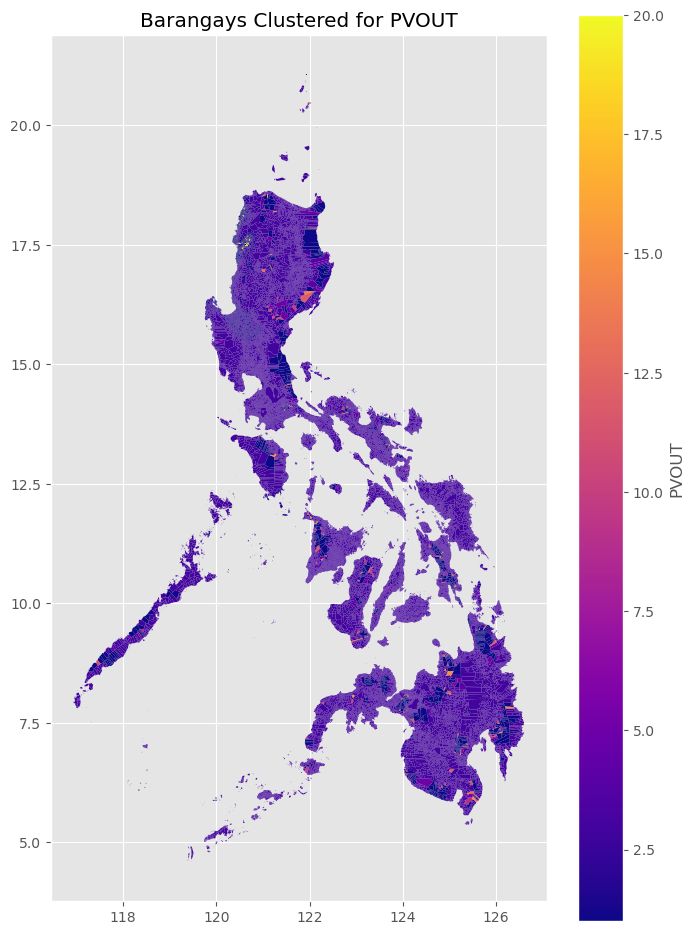

In [19]:
fig, ax = plt.subplots(figsize=(8,12))
ph_cluster_dbscan.plot(column= 'Cluster', ax=ax, legend = True, cmap='plasma', 
             legend_kwds = {'label':'PVOUT'})
plt.title('Barangays Clustered for PVOUT')

In [20]:
ph_cluster_dbscan.to_file(driver='GeoJSON', filename = "data/results/dbscan/ph_clustered.geojson")

In [21]:
ph_cluster_dbscan.to_file(driver = 'ESRI Shapefile', filename= "data/results/dbscan/ph_clustered.shp")

In [24]:
pv_out_per_cluster_summary = ph_cluster_dbscan.groupby('Cluster').agg({'PVOUT_mean': ['mean', 'min', 'max','count']})
pv_out_per_cluster_summary

PVOUT_mean                                 
                mean          min          max  count
Cluster                                              
1        1412.332809   177.000000  1695.307983   2107
2        1599.697375  1572.423222  1624.388631   2529
3        1426.225744  1299.834480  1572.401520  36361
4        1295.277297  1290.687057  1299.787735    302
5        1287.319921  1283.910008  1290.617183    233
6        1268.720555  1268.269674  1269.122030     26
7        1627.699407  1626.951492  1628.467010     50
8        1649.734913  1649.115043  1650.266419     35
9        1277.883573  1277.419621  1278.375195     28
10       1282.076028  1281.449341  1282.747657     38
11       1261.660675  1260.841891  1262.450195     47
12       1256.109117  1255.563535  1256.642456     29
13       1283.543250  1283.245036  1283.801592     16
14       1270.852072  1270.558618  1271.252686     20
15       1267.506495  1267.031332  1267.904541     25
16       1650.593398  1650.356027  1650.759759      9
17       1657.483404  1657.117137  1657.972013     25
18       1651.135733  1650.825718  1651.450318     19
19       1648.786865  1648.669265  1648.981689     12
20       1646.974940  1646.623234  1647.310877     22

In [25]:
pv_out_per_cluster_summary.to_csv("data/results/dbscan/ph_clusters_summary.csv")